In [271]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [272]:
# load the ratings data
ratings_df = pd.read_csv("data/ratings.csv").drop("timestamp", axis=1)

In [273]:
# split the data into test and train sets
test_ratings = ratings_df.sample(int(len(ratings_df)*0.2), random_state=0xc00ff3)
sampled_indices = test_ratings.index

test_pairs =  test_ratings[["userId", "movieId"]]
actual_ratings = test_ratings["rating"]

train_ratings = ratings_df.drop(sampled_indices)

del ratings_df

In [274]:
# load movie data
movies_df = pd.read_csv("data/movies.csv").drop("title", axis=1)
movies_df

,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy
...,...,...
9737,193581,Action|Animation|Comedy|Fantasy
9738,193583,Animation|Comedy|Fantasy
9739,193585,Drama
9740,193587,Action|Animation


In [275]:
# merge movies with ratings
train_ratings_merged = pd.merge(train_ratings, movies_df, on="movieId")
train_ratings_merged

,userId,movieId,rating,genres
0,1,1,4.0,Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...
80664,610,160527,4.5,Action|Crime|Drama
80665,610,160571,3.0,Horror
80666,610,160836,3.0,Action|Drama|Thriller
80667,610,163937,3.5,Horror|Thriller


In [276]:
# split genres column into separable rows
train_ratings_merged["genres"] = train_ratings_merged["genres"].str.split("|") 
train_ratings_merged = train_ratings_merged.explode('genres').reset_index(drop=True)
train_ratings_merged

,userId,movieId,rating,genres
0,1,1,4.0,Adventure
1,1,1,4.0,Animation
2,1,1,4.0,Children
3,1,1,4.0,Comedy
4,1,1,4.0,Fantasy
...,...,...,...,...
219788,610,160836,3.0,Drama
219789,610,160836,3.0,Thriller
219790,610,163937,3.5,Horror
219791,610,163937,3.5,Thriller


In [277]:
movies_df.groupby("genres").count()
# we will delete no genres because it is not good for similarity comparison

,movieId
genres,
(no genres listed),34
Action,60
Action|Adventure,32
Action|Adventure|Animation,18
Action|Adventure|Animation|Children,6
...,...
Sci-Fi|Thriller,23
Sci-Fi|Thriller|IMAX,1
Thriller,84


In [278]:
# check average genre score
average_genre_score = train_ratings_merged.drop(["userId", "movieId"], axis=1).groupby("genres").mean()
genre_avg_score_map = average_genre_score['rating'].to_dict()
average_genre_score

,rating
genres,
(no genres listed),3.392857
Action,3.444614
Adventure,3.511280
Animation,3.635266
Children,3.415320
Comedy,3.388298
Crime,3.659421
Documentary,3.800513
Drama,3.654682


In [279]:
# prepare data for training
# create pivot table: rows = userId, columns genres
# into cell feel with mean value of grades from specyfic genre for specyfic user
# drop '(no genres listed)' column
# fill NA with average for given genre
X = train_ratings_merged.pivot_table(index="userId", columns="genres", values="rating", aggfunc="mean").drop("(no genres listed)", axis=1).fillna(genre_avg_score_map)
X


genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,4.333333,4.400000,4.653846,4.552632,4.328571,4.425000,3.800513,4.472727,4.382353,5.000000,3.583333,3.621993,4.650000,4.062500,4.347826,4.250000,4.152174,4.411765,4.166667
2,3.900000,4.166667,3.635266,3.415320,4.000000,3.800000,4.333333,3.933333,3.486832,3.930334,3.000000,3.750000,3.551243,4.000000,4.500000,3.875000,3.833333,3.803266,3.500000
3,3.400000,2.555556,0.500000,0.500000,1.250000,0.500000,3.800513,0.807692,3.375000,3.930334,4.800000,3.621993,3.551243,3.625345,0.500000,4.166667,4.000000,0.500000,3.583066
4,3.136364,3.363636,4.000000,3.750000,3.441558,3.894737,3.000000,3.389474,3.692308,5.000000,4.000000,3.621993,3.800000,3.368421,3.261905,2.500000,3.466667,3.333333,3.571429
5,3.125000,3.250000,4.200000,4.000000,3.538462,3.875000,3.800513,3.777778,4.200000,3.930334,3.000000,3.666667,4.250000,3.625345,3.111111,2.500000,3.666667,3.333333,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.170635,3.483607,3.661765,3.375000,3.543544,3.668224,3.750000,3.781961,3.601266,3.857143,3.410256,3.038462,3.742857,3.801370,3.728873,3.532787,3.553459,3.745455,3.392857
607,3.763636,3.657143,3.333333,3.692308,3.268293,3.588235,3.800513,4.120690,3.631579,3.930334,4.068966,5.000000,3.750000,4.666667,3.739130,3.400000,4.276596,5.000000,4.000000
608,3.340000,3.223776,3.122222,2.400000,2.766667,3.622951,3.200000,3.468610,2.938202,3.750000,3.298611,4.150000,2.857143,3.620370,2.906977,3.295620,3.559809,3.593750,2.928571


In [280]:
best_k = 14

In [281]:
kmeans = KMeans(n_clusters=best_k, init="k-means++", random_state=0xc00ff3).fit(X)

/home/wojtek/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9162f91a80>
Traceback (most recent call last):
  File "/home/wojtek/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/wojtek/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wojtek/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
        

In [282]:
# assign user to the cluster
user_clusters = pd.DataFrame({"userId": X.index, "cluster": kmeans.labels_}).set_index("userId")
user_clusters

,cluster
userId,
1,2
2,7
3,8
4,0
5,0
...,...
606,11
607,12
608,1


In [283]:
# write to csv
user_clusters.to_csv('user_cluster.csv') 

<Axes: xlabel='cluster', ylabel='count'>

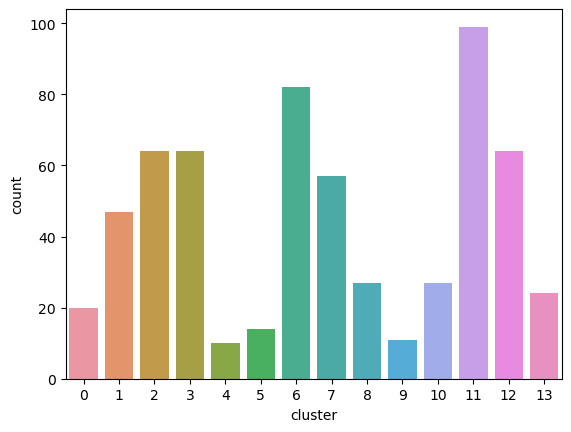

In [284]:
# show distribution of user in every cluster
sns.countplot(data = user_clusters, x = "cluster")

In [285]:
# merge ratings with clusters
cluster_ratings = pd.merge(train_ratings, user_clusters, how="left", on="userId").drop("userId", axis=1)
cluster_ratings

,movieId,rating,cluster
0,1,4.0,2
1,3,4.0,2
2,6,4.0,2
3,50,5.0,2
4,70,3.0,2
...,...,...,...
80664,164179,5.0,6
80665,166528,4.0,6
80666,168248,5.0,6
80667,168250,5.0,6


In [286]:
# group by cluster and movieId and calculate mean
cluster_ratings = cluster_ratings.groupby(["cluster", "movieId"]).mean()
cluster_ratings

rating
cluster movieId        
0       1           3.8
        2           3.4
        3           2.5
        4           2.0
        6           4.0
...                 ...
13      129428      3.5
        130482      4.0
        136020      5.0
        136850      5.0
        140110      5.0

[30785 rows x 1 columns]

In [287]:
# write cluster_ratings
cluster_ratings.to_csv('cluster_ratings.csv') 

In [288]:
average_ranking = train_ratings["rating"].mean()

In [289]:
average_ranking

3.5012520298999616

In [290]:
average_rating = train_ratings.drop("userId",axis=1).groupby(["movieId"]).mean()

In [291]:
# predict function
def predict(user_id, movie_id):
    if user_id not in user_clusters.index:
        return average_ranking
    
    cluster = int(user_clusters.loc[user_id, "cluster"])
    
    try:
        rating = cluster_ratings.loc[(cluster, movie_id), "rating"]
        
    except KeyError:
        rating = train_ratings.loc[train_ratings["movieId"] == movie_id]["rating"].mean()
        if np.isnan(rating):
            return average_ranking
        else:
            
            return rating

        
    return rating

In [292]:
# check prediction for average
just_averages = train_ratings.drop("userId", axis=1).groupby("movieId").mean()

In [293]:
c = 0
def just_average_predict(user_id, movie_id):
    global c
    try:
        rating = just_averages.at[movie_id, "rating"]
    except KeyError:
        rating = average_ranking
        c += 1
    return rating

In [294]:
# predict rating for test data
y_predicted = test_pairs.apply(lambda row: predict(row['userId'], row['movieId']), axis=1)

# predict rating 
y_predicted_average = test_pairs.apply(lambda row: just_average_predict(row['userId'], row['movieId']), axis=1)

print("MSE for average")
print(mean_squared_error(y_predicted_average, actual_ratings))


print("MSE for the model")
print(mean_squared_error(y_predicted, actual_ratings))

MSE for average
0.9404938436807428
MSE for the model
1.0174544709424465
